In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define path
zip_path = "/content/fraud_detection.zip"
extract_path = "/content/fraud_data"

# Check if the zip file exists
if not os.path.exists(zip_path):
    print(f"Error: Zip file not found at {zip_path}")
else:
    # Check if the file is a valid zip file
    if not zipfile.is_zipfile(zip_path):
        print(f"Error: The file at {zip_path} is not a valid zip file.")
    else:
        # Unzip
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Successfully extracted to {extract_path}")

        # Confirm extraction
        if os.path.exists(extract_path):
            print("Extracted files:", os.listdir(extract_path))
        else:
            print("Extraction failed, directory not found.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted to /content/fraud_data
Extracted files: ['fraud_detection']


In [ ]:
import pandas as pd
from tqdm import tqdm

# Path to daily files
data_dir = '/content/fraud_data/fraud_detection/data/data'
all_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".pkl")])

# Load all pkl files
all_dfs = []
for file in tqdm(all_files, desc="Loading all files"):
    df = pd.read_pickle(os.path.join(data_dir, file))
    all_dfs.append(df)

# Merge into single DataFrame
df_all = pd.concat(all_dfs, ignore_index=True)

# Quick summary
print("✅ Total transactions:", df_all.shape[0])
df_all.head()

Loading all files: 100%|██████████| 183/183 [00:17<00:00, 10.66it/s]


✅ Total transactions: 1754155


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Overview
print(df_all.info())
print(df_all.describe())

# Check for missing values
print("\n🔍 Missing Values:\n", df_all.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.4+ MB
None
       TRANSACTION_ID                    TX_DATETIME     TX_AMOUNT  \
count    1.754155e+06                        1754155  1.754155e+06   
mean     8.770770e+05  2018-07-01 11:20:33.708572160  5.363230e+01   
min      0.000000e+00            2018-04-01 00:00:31  0.000000e+00   
25%      4.385385e+05     2018-05-16 14:40:46.500000  2.101000e+01   
50%      8.770770e+05

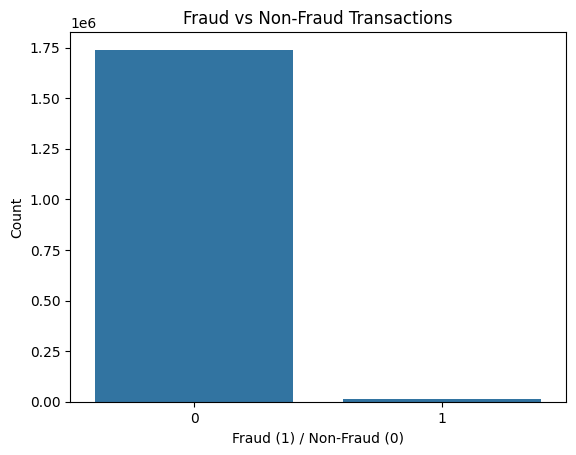

⚠️ Fraudulent transactions rate: 0.8369%


In [ ]:
# Class distribution
sns.countplot(data=df_all, x='TX_FRAUD')
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Fraud (1) / Non-Fraud (0)")
plt.ylabel("Count")
plt.show()

# Percentage
fraud_rate = df_all['TX_FRAUD'].mean() * 100
print(f"⚠️ Fraudulent transactions rate: {fraud_rate:.4f}%")

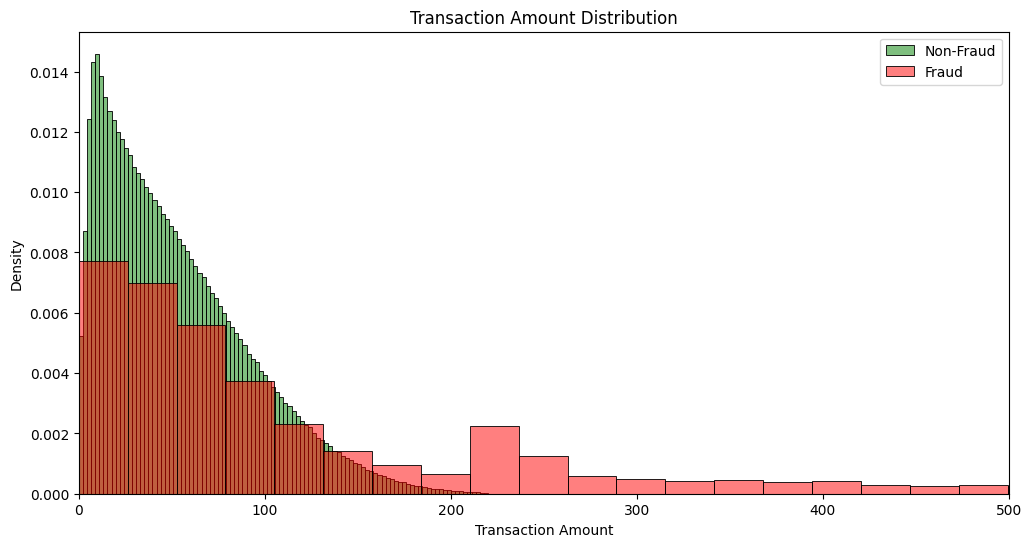

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df_all[df_all['TX_FRAUD'] == 0]['TX_AMOUNT'], bins=100, label='Non-Fraud', color='green', stat='density', alpha=0.5)
sns.histplot(df_all[df_all['TX_FRAUD'] == 1]['TX_AMOUNT'], bins=100, label='Fraud', color='red', stat='density', alpha=0.5)
plt.legend()
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.xlim(0, 500)  # zoom in to see patterns
plt.show()

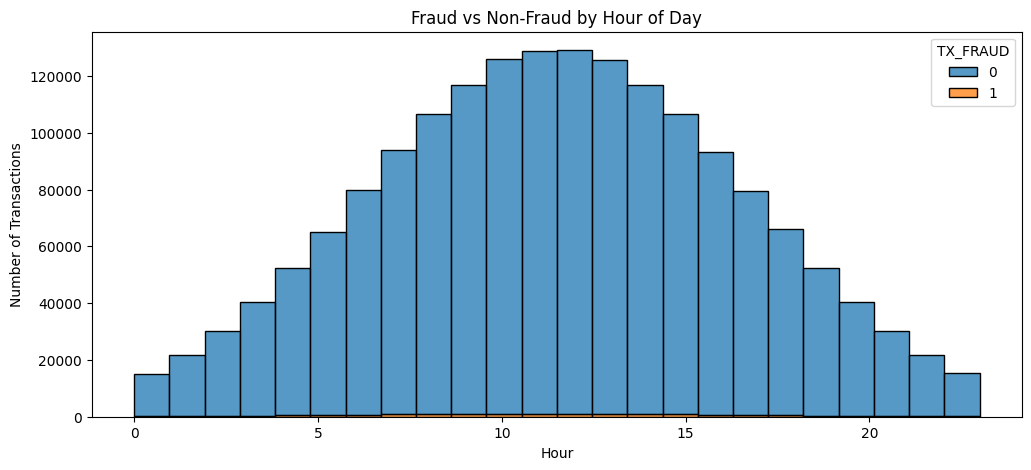

In [ ]:
# Convert to datetime if not already
df_all['TX_DATETIME'] = pd.to_datetime(df_all['TX_DATETIME'])

# Create hour and day features
df_all['TX_HOUR'] = df_all['TX_DATETIME'].dt.hour
df_all['TX_DAY'] = df_all['TX_DATETIME'].dt.date

# Fraud by hour of day
plt.figure(figsize=(12, 5))
sns.histplot(data=df_all, x='TX_HOUR', hue='TX_FRAUD', multiple='stack', bins=24)
plt.title("Fraud vs Non-Fraud by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Transactions")
plt.show()

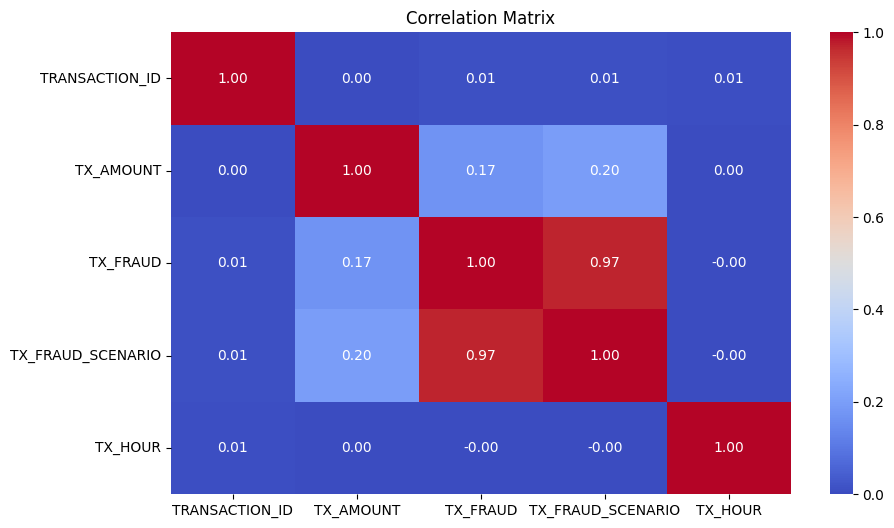

In [ ]:
# Select only numeric columns
numeric_cols = df_all.select_dtypes(include='number')

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

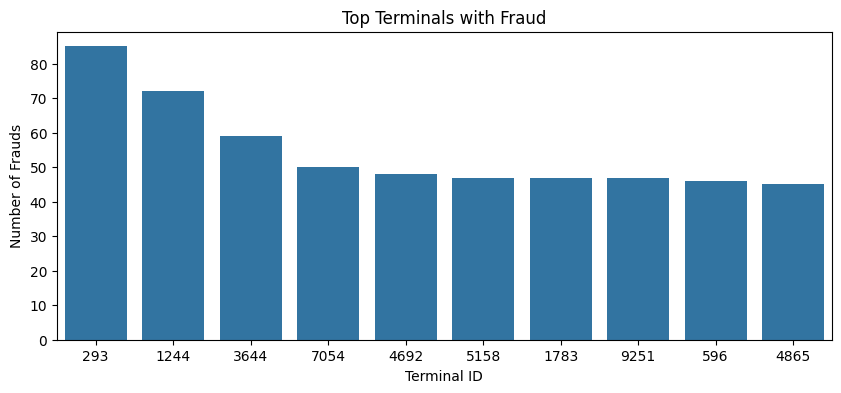

In [ ]:
# Top terminals with fraud
top_fraud_terminals = df_all[df_all['TX_FRAUD'] == 1]['TERMINAL_ID'].value_counts().head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=top_fraud_terminals.index.astype(str), y=top_fraud_terminals.values)
plt.title("Top Terminals with Fraud")
plt.xlabel("Terminal ID")
plt.ylabel("Number of Frauds")
plt.show()

In [ ]:
# Convert TX_DATETIME if not already
df_all['TX_DATETIME'] = pd.to_datetime(df_all['TX_DATETIME'])

# Create basic time features
df_all['TX_HOUR'] = df_all['TX_DATETIME'].dt.hour
df_all['TX_DAY'] = df_all['TX_DATETIME'].dt.day
df_all['TX_WEEKDAY'] = df_all['TX_DATETIME'].dt.weekday
df_all['TX_MONTH'] = df_all['TX_DATETIME'].dt.month

In [ ]:
# Count of transactions per customer per day
df_all['TX_DATE'] = df_all['TX_DATETIME'].dt.date

tx_count_per_customer = df_all.groupby(['CUSTOMER_ID', 'TX_DATE'])['TRANSACTION_ID'].count().reset_index()
tx_count_per_customer.rename(columns={'TRANSACTION_ID': 'TX_COUNT_CUST_PER_DAY'}, inplace=True)

# Merge back to main DataFrame
df_all = df_all.merge(tx_count_per_customer, on=['CUSTOMER_ID', 'TX_DATE'], how='left')

In [ ]:
df_all = df_all.sort_values(by='TX_DATETIME')

# Example: rolling mean transaction amount over last N transactions per customer
df_all['TX_AMOUNT_MEAN_CUST'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(lambda x: x.rolling(5, min_periods=1).mean())
df_all['TX_AMOUNT_STD_CUST'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(lambda x: x.rolling(5, min_periods=1).std().fillna(0))

In [ ]:
# Cumulative fraud rate per terminal
df_all['CUM_TX'] = df_all.groupby('TERMINAL_ID').cumcount() + 1
df_all['CUM_FRAUD'] = df_all.groupby('TERMINAL_ID')['TX_FRAUD'].cumsum()
df_all['TERMINAL_FRAUD_RATE'] = df_all['CUM_FRAUD'] / df_all['CUM_TX']

In [ ]:
df_all_model = df_all.drop(columns=[
    'TRANSACTION_ID', 'TX_DATETIME', 'TX_DATE',
    'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD_SCENARIO'
])

['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT',
 'TX_HOUR', 'TX_DAY', 'TX_WEEKDAY', 'TX_MONTH',
 'TX_COUNT_CUST_PER_DAY', 'TX_AMOUNT_MEAN_CUST', 'TX_AMOUNT_STD_CUST',
 'TERMINAL_FRAUD_RATE', 'TX_FRAUD']

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [
    'TX_AMOUNT', 'TX_HOUR', 'TX_DAY', 'TX_WEEKDAY', 'TX_MONTH',
    'TX_COUNT_CUST_PER_DAY', 'TX_AMOUNT_MEAN_CUST', 'TX_AMOUNT_STD_CUST',
    'TERMINAL_FRAUD_RATE'
]
target = 'TX_FRAUD'

X = df_all_model[features]
y = df_all_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:30:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)


📌 Random Forest Evaluation:
              precision    recall  f1-score   support

           0     0.9981    0.9912    0.9946    347895
           1     0.4253    0.7718    0.5484      2936

    accuracy                         0.9894    350831
   macro avg     0.7117    0.8815    0.7715    350831
weighted avg     0.9933    0.9894    0.9909    350831

ROC AUC Score: 0.9810715574396781


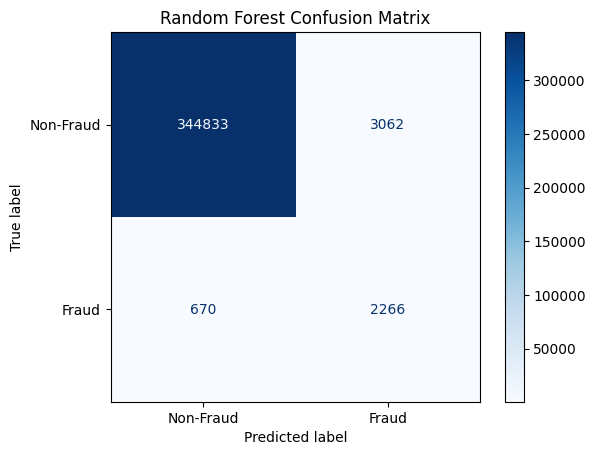

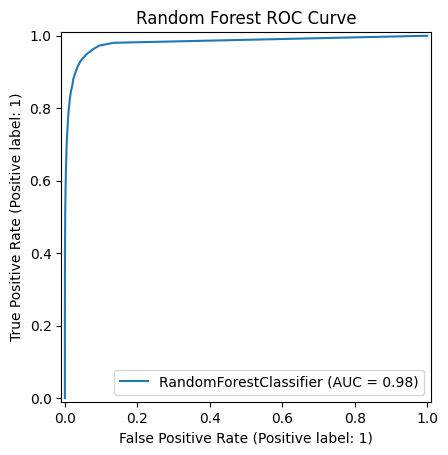


📌 XGBoost Evaluation:
              precision    recall  f1-score   support

           0     0.9988    0.9784    0.9885    347895
           1     0.2524    0.8627    0.3906      2936

    accuracy                         0.9775    350831
   macro avg     0.6256    0.9206    0.6896    350831
weighted avg     0.9926    0.9775    0.9835    350831

ROC AUC Score: 0.9880787121478328


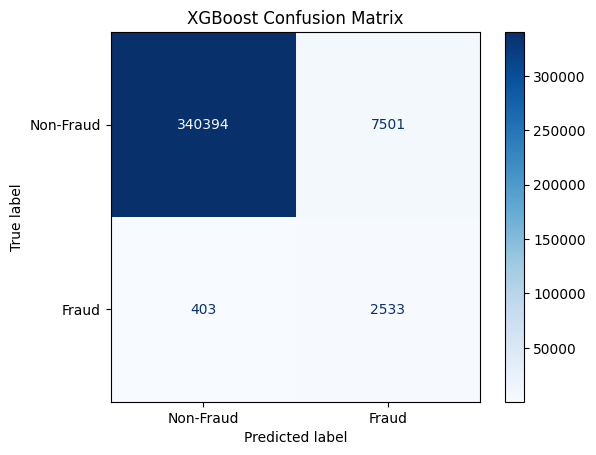

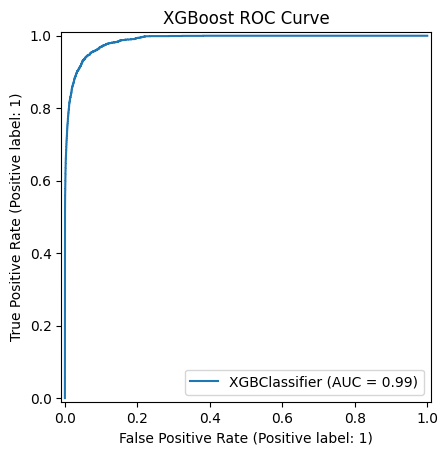

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# Evaluate on test set
models = {'Random Forest': rf, 'XGBoost': xgb}

for name, model in models.items():
    print(f"\n📌 {name} Evaluation:")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Non-Fraud", "Fraud"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()

In [ ]:
from imblearn.pipeline import Pipeline          # imblearn's Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (StratifiedKFold,
                                     GridSearchCV,
                                     RandomizedSearchCV)
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# Use the same feature matrix X and target y you created earlier
# ------------------------------------------------------------
# 1.  Cross‑validation scheme & scorers
# ------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorers = {
    "F1"      : make_scorer(f1_score, average="binary"),
    "ROC_AUC" : "roc_auc"
}

# ------------------------------------------------------------
# 2‑A.  Random Forest – GridSearch
# ------------------------------------------------------------
rf_pipe = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_param_grid = {
    "model__n_estimators"     : [200, 400, 600],
    "model__max_depth"        : [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf" : [1, 2, 4],
    "model__class_weight"     : ["balanced", {0:1, 1:10}]  # tweak
}

rf_grid = GridSearchCV(
    estimator   = rf_pipe,
    param_grid  = rf_param_grid,
    scoring     = scorers,
    refit       = "ROC_AUC",
    cv          = cv,
    n_jobs      = -1,
    verbose     = 2
)
rf_grid.fit(X, y)

print("🔎 Best RF params:", rf_grid.best_params_)
print("🏆 Best RF ROC‑AUC:", rf_grid.best_score_)

# ------------------------------------------------------------
# 2‑B.  XGBoost – RandomizedSearch (quicker on big grids)
# ------------------------------------------------------------
xgb_pipe = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        objective         = "binary:logistic",
        eval_metric       = "auc",
        tree_method       = "hist",      # GPU? use "gpu_hist"
        n_jobs            = -1,
        random_state      = 42
    ))
])

xgb_param_dist = {
    "model__n_estimators"     : np.linspace(300, 1200, 10, dtype=int),
    "model__learning_rate"    : np.logspace(-3, -1, 5),
    "model__max_depth"        : [3, 4, 5, 6, 8],
    "model__subsample"        : [0.6, 0.8, 1.0],
    "model__colsample_bytree" : [0.6, 0.8, 1.0],
    "model__gamma"            : [0, 0.1, 0.5, 1],
    "model__min_child_weight" : [1, 5, 10],
    "model__scale_pos_weight" : [1, 5, 10]   # label imbalance
}

xgb_rand = RandomizedSearchCV(
    estimator   = xgb_pipe,
    param_distributions = xgb_param_dist,
    n_iter      = 50,          # tune for speed/accuracy trade‑off
    scoring     = scorers,
    refit       = "ROC_AUC",
    cv          = cv,
    n_jobs      = -1,
    verbose     = 2,
    random_state= 42
)
xgb_rand.fit(X, y)

print("🔎 Best XGB params:", xgb_rand.best_params_)
print("🏆 Best XGB ROC‑AUC:", xgb_rand.best_score_)

# ------------------------------------------------------------
# 3.  Evaluate the tuned models on the held‑out test set
# ------------------------------------------------------------
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

best_rf  = rf_grid.best_estimator_
best_xgb = xgb_rand.best_estimator_

for name, model in [("Random Forest (tuned)", best_rf),
                    ("XGBoost (tuned)",      best_xgb)]:
    print(f"\n=== {name} ===")
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred, digits=4))
    print("ROC‑AUC:", roc_auc_score(y_test, y_proba))

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                          display_labels=["Non‑Fraud","Fraud"],
                                          cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} – ROC Curve")
    plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
import joblib
joblib.dump(best_xgb, "best_xgb_fraud_detector.pkl")

In [ ]:
# List the contents of the extraction directory to see the structure
!ls -R /content/fraud_data

In [ ]:
import zipfile
import os

# Path to the nested zip file
nested_zip_path = '/content/fraud_data/fraud_detection/dataset.zip'
extract_nested_path = '/content/fraud_data/fraud_detection/data'

# Unzip the nested zip file
with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_nested_path)

print(f"Successfully extracted nested zip to {extract_nested_path}")
print("Extracted files:", os.listdir(extract_nested_path))